# Import Library

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Scraping

In [5]:
# List ticker untuk saham 10 perusahaan Indonesia
tickers = ['BBCA.JK', 'BYAN.JK', 'TPIA.JK', 'BBRI.JK', 'BMRI.JK', 'DSSA.JK', 'TLKM.JK', 'ASII.JK', 'BBNI.JK', 'ICBP.JK']

# Download data harga penutupan (adjusted close) untuk setiap perusahaan dengan interval 1 hari
stock_datas = {}
for ticker in tickers:
  df = yf.download(ticker, start='2018-01-01', end='2025-05-15', interval='1d')
  stock_datas[ticker] = df['Close']

# Gabung semua jadi 1 dataframe
df_all = pd.concat(stock_datas, axis=1)
df_all.columns = tickers

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
df_all

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2018-01-01,3723.926270,711.824524,1457.917725,2289.992676,2592.610352,1390.0,3430.840088,5748.219238,3732.603760,7525.144531
2018-01-02,3723.926270,718.539795,1439.693481,2283.701416,2543.998779,1410.0,3407.658936,5678.963379,3685.474609,7694.248047
2018-01-03,3723.926270,718.539795,1403.245850,2271.118896,2495.387207,1390.0,3268.570801,5575.079590,3553.514404,7694.248047
2018-01-04,3779.190186,711.824524,1348.573608,2233.371826,2535.896973,1390.0,3260.843506,5696.277344,3544.088379,7715.386719
2018-01-05,3783.440674,715.182190,1385.021606,2258.536621,2535.896973,1390.0,3307.206543,5748.219238,3506.385254,7842.216309
...,...,...,...,...,...,...,...,...,...,...
2025-05-06,9025.000000,20150.000000,8700.000000,3880.000000,4980.000000,48200.0,2680.000000,4750.000000,4180.000000,11275.000000
2025-05-07,9075.000000,20225.000000,9025.000000,3910.000000,4950.000000,48700.0,2620.000000,4830.000000,4160.000000,11075.000000
2025-05-08,8975.000000,20225.000000,8875.000000,3790.000000,4790.000000,48250.0,2570.000000,4780.000000,4120.000000,11400.000000


# Data Preprocessing

## Menangani Missing Value

In [7]:
df_all.isnull().sum()

BBCA.JK    0
BYAN.JK    0
TPIA.JK    0
BBRI.JK    0
BMRI.JK    0
DSSA.JK    0
TLKM.JK    1
ASII.JK    1
BBNI.JK    0
ICBP.JK    1
dtype: int64

In [8]:
# Melihat baris yang bernilai null
df_all[df_all.isnull().any(axis=1)]

,BBCA.JK,BYAN.JK,TPIA.JK,BBRI.JK,BMRI.JK,DSSA.JK,TLKM.JK,ASII.JK,BBNI.JK,ICBP.JK
Date,,,,,,,,,,
2019-06-19,5152.053711,1144.98999,1209.519653,2880.275635,2881.316895,1450.0,NaN,NaN,3534.166504,NaN


In [9]:
df_all.dropna(inplace=True)
df_all.isnull().sum()

BBCA.JK    0
BYAN.JK    0
TPIA.JK    0
BBRI.JK    0
BMRI.JK    0
DSSA.JK    0
TLKM.JK    0
ASII.JK    0
BBNI.JK    0
ICBP.JK    0
dtype: int64

In [10]:
df_all.shape

(1810, 10)

## Mengganti Nama Kolom

In [11]:
df_all.columns = df_all.columns.str.replace('.JK', '', regex=False)
df_all

,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
Date,,,,,,,,,,
2018-01-01,3723.926270,711.824524,1457.917725,2289.992676,2592.610352,1390.0,3430.840088,5748.219238,3732.603760,7525.144531
2018-01-02,3723.926270,718.539795,1439.693481,2283.701416,2543.998779,1410.0,3407.658936,5678.963379,3685.474609,7694.248047
2018-01-03,3723.926270,718.539795,1403.245850,2271.118896,2495.387207,1390.0,3268.570801,5575.079590,3553.514404,7694.248047
2018-01-04,3779.190186,711.824524,1348.573608,2233.371826,2535.896973,1390.0,3260.843506,5696.277344,3544.088379,7715.386719
2018-01-05,3783.440674,715.182190,1385.021606,2258.536621,2535.896973,1390.0,3307.206543,5748.219238,3506.385254,7842.216309
...,...,...,...,...,...,...,...,...,...,...
2025-05-06,9025.000000,20150.000000,8700.000000,3880.000000,4980.000000,48200.0,2680.000000,4750.000000,4180.000000,11275.000000
2025-05-07,9075.000000,20225.000000,9025.000000,3910.000000,4950.000000,48700.0,2620.000000,4830.000000,4160.000000,11075.000000
2025-05-08,8975.000000,20225.000000,8875.000000,3790.000000,4790.000000,48250.0,2570.000000,4780.000000,4120.000000,11400.000000


## Menambah Fitur Tanggal

Dilakukan pengubahan data tanggal dari index menjadi kolom date

In [12]:
df_all = df_all.reset_index()
df_all

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926270,711.824524,1457.917725,2289.992676,2592.610352,1390.0,3430.840088,5748.219238,3732.603760,7525.144531
1,2018-01-02,3723.926270,718.539795,1439.693481,2283.701416,2543.998779,1410.0,3407.658936,5678.963379,3685.474609,7694.248047
2,2018-01-03,3723.926270,718.539795,1403.245850,2271.118896,2495.387207,1390.0,3268.570801,5575.079590,3553.514404,7694.248047
3,2018-01-04,3779.190186,711.824524,1348.573608,2233.371826,2535.896973,1390.0,3260.843506,5696.277344,3544.088379,7715.386719
4,2018-01-05,3783.440674,715.182190,1385.021606,2258.536621,2535.896973,1390.0,3307.206543,5748.219238,3506.385254,7842.216309
...,...,...,...,...,...,...,...,...,...,...,...
1805,2025-05-06,9025.000000,20150.000000,8700.000000,3880.000000,4980.000000,48200.0,2680.000000,4750.000000,4180.000000,11275.000000
1806,2025-05-07,9075.000000,20225.000000,9025.000000,3910.000000,4950.000000,48700.0,2620.000000,4830.000000,4160.000000,11075.000000
1807,2025-05-08,8975.000000,20225.000000,8875.000000,3790.000000,4790.000000,48250.0,2570.000000,4780.000000,4120.000000,11400.000000
1808,2025-05-09,9000.000000,20200.000000,8525.000000,3840.000000,4770.000000,49325.0,2600.000000,4780.000000,4100.000000,11200.000000


## Menangani Duplikasi Data

In [13]:
print("Jumlah duplikasi data:", df_all.duplicated().sum())

Jumlah duplikasi data: 0


## Mengurutkan data

Karena data yang dibutuhkan merupakan data time series, maka datanya harus berurutan berdasarkan waktu (Kolom `Date`)

In [14]:
df_all = df_all.sort_values(by="Date", ascending=True)
df_all

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
0,2018-01-01,3723.926270,711.824524,1457.917725,2289.992676,2592.610352,1390.0,3430.840088,5748.219238,3732.603760,7525.144531
1,2018-01-02,3723.926270,718.539795,1439.693481,2283.701416,2543.998779,1410.0,3407.658936,5678.963379,3685.474609,7694.248047
2,2018-01-03,3723.926270,718.539795,1403.245850,2271.118896,2495.387207,1390.0,3268.570801,5575.079590,3553.514404,7694.248047
3,2018-01-04,3779.190186,711.824524,1348.573608,2233.371826,2535.896973,1390.0,3260.843506,5696.277344,3544.088379,7715.386719
4,2018-01-05,3783.440674,715.182190,1385.021606,2258.536621,2535.896973,1390.0,3307.206543,5748.219238,3506.385254,7842.216309
...,...,...,...,...,...,...,...,...,...,...,...
1805,2025-05-06,9025.000000,20150.000000,8700.000000,3880.000000,4980.000000,48200.0,2680.000000,4750.000000,4180.000000,11275.000000
1806,2025-05-07,9075.000000,20225.000000,9025.000000,3910.000000,4950.000000,48700.0,2620.000000,4830.000000,4160.000000,11075.000000
1807,2025-05-08,8975.000000,20225.000000,8875.000000,3790.000000,4790.000000,48250.0,2570.000000,4780.000000,4120.000000,11400.000000
1808,2025-05-09,9000.000000,20200.000000,8525.000000,3840.000000,4770.000000,49325.0,2600.000000,4780.000000,4100.000000,11200.000000


# Data Exploration

## Deskripsi Variabel

Setiap kolom berisi harga saham penutupan (adjusted close) dari top 20 emiten Indonesia

In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1810 entries, 0 to 1809
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1810 non-null   datetime64[ns]
 1   BBCA    1810 non-null   float64       
 2   BYAN    1810 non-null   float64       
 3   TPIA    1810 non-null   float64       
 4   BBRI    1810 non-null   float64       
 5   BMRI    1810 non-null   float64       
 6   DSSA    1810 non-null   float64       
 7   TLKM    1810 non-null   float64       
 8   ASII    1810 non-null   float64       
 9   BBNI    1810 non-null   float64       
 10  ICBP    1810 non-null   float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 155.7 KB


Terdapat nilai null pada beberapa kolom

In [16]:
df_all.describe()

,Date,BBCA,BYAN,TPIA,BBRI,BMRI,DSSA,TLKM,ASII,BBNI,ICBP
count,1810,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000,1810.000000
mean,2021-08-10 13:43:25.524861696,6575.986153,7173.615920,2982.287483,3292.435647,3455.540751,7408.541436,3137.924500,4831.697258,3368.647306,9228.747386
min,2018-01-01 00:00:00,3529.552734,587.591064,1093.920654,1513.757080,1411.886841,920.000000,2070.656006,2403.470215,1292.781372,6683.181152
25%,2019-09-26 06:00:00,5048.401733,1156.325195,1685.613037,2510.710205,2476.076416,1472.500000,2800.138672,4469.868652,2795.217529,8024.524414
50%,2021-08-05 12:00:00,6046.030273,1411.680298,2229.064209,3194.934326,2793.075439,2125.000000,3054.104370,4879.496582,3402.971191,9091.309570
75%,2023-06-13 18:00:00,8332.747314,17226.738281,2561.828125,3962.136047,4429.971680,4900.000000,3522.970825,5245.840210,3967.650879,10371.634766
max,2025-05-14 00:00:00,10570.414062,22388.601562,10625.000000,5763.100098,6769.004883,49900.000000,4295.701172,6127.019531,5460.848145,12800.000000
std,NaN,1891.751845,7836.429406,2298.827043,929.159407,1333.504766,11882.485410,462.369001,673.876936,887.833937,1388.437075


## Analisis Harga Saham Tiap Perusahaan

In [20]:
dates = df_all['Date']
stocks = df_all.drop(columns='Date')

<Figure size 1400x600 with 0 Axes>

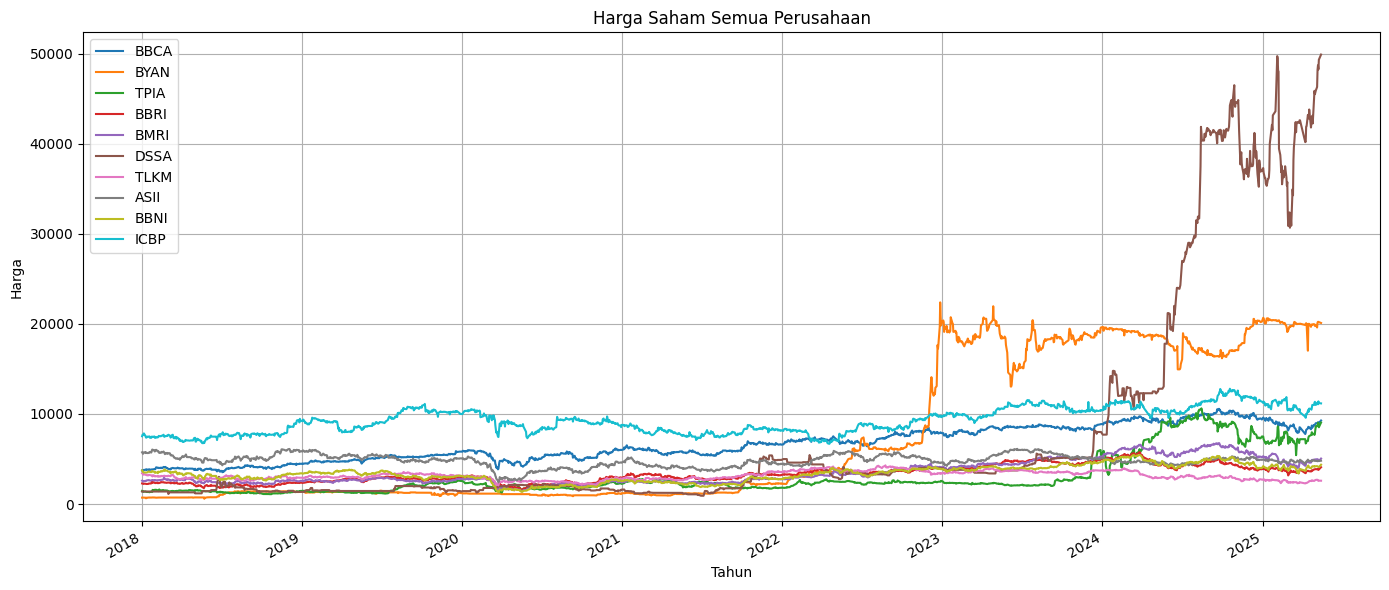

In [39]:
plt.figure(figsize=(14, 6))
stocks.index = dates  # ubah dates jadi index 
stocks.plot(figsize=(14, 6))
plt.ylabel("Harga")
plt.xlabel("Tahun")
plt.title("Harga Saham Semua Perusahaan")
plt.grid(True)
plt.tight_layout()
plt.show()

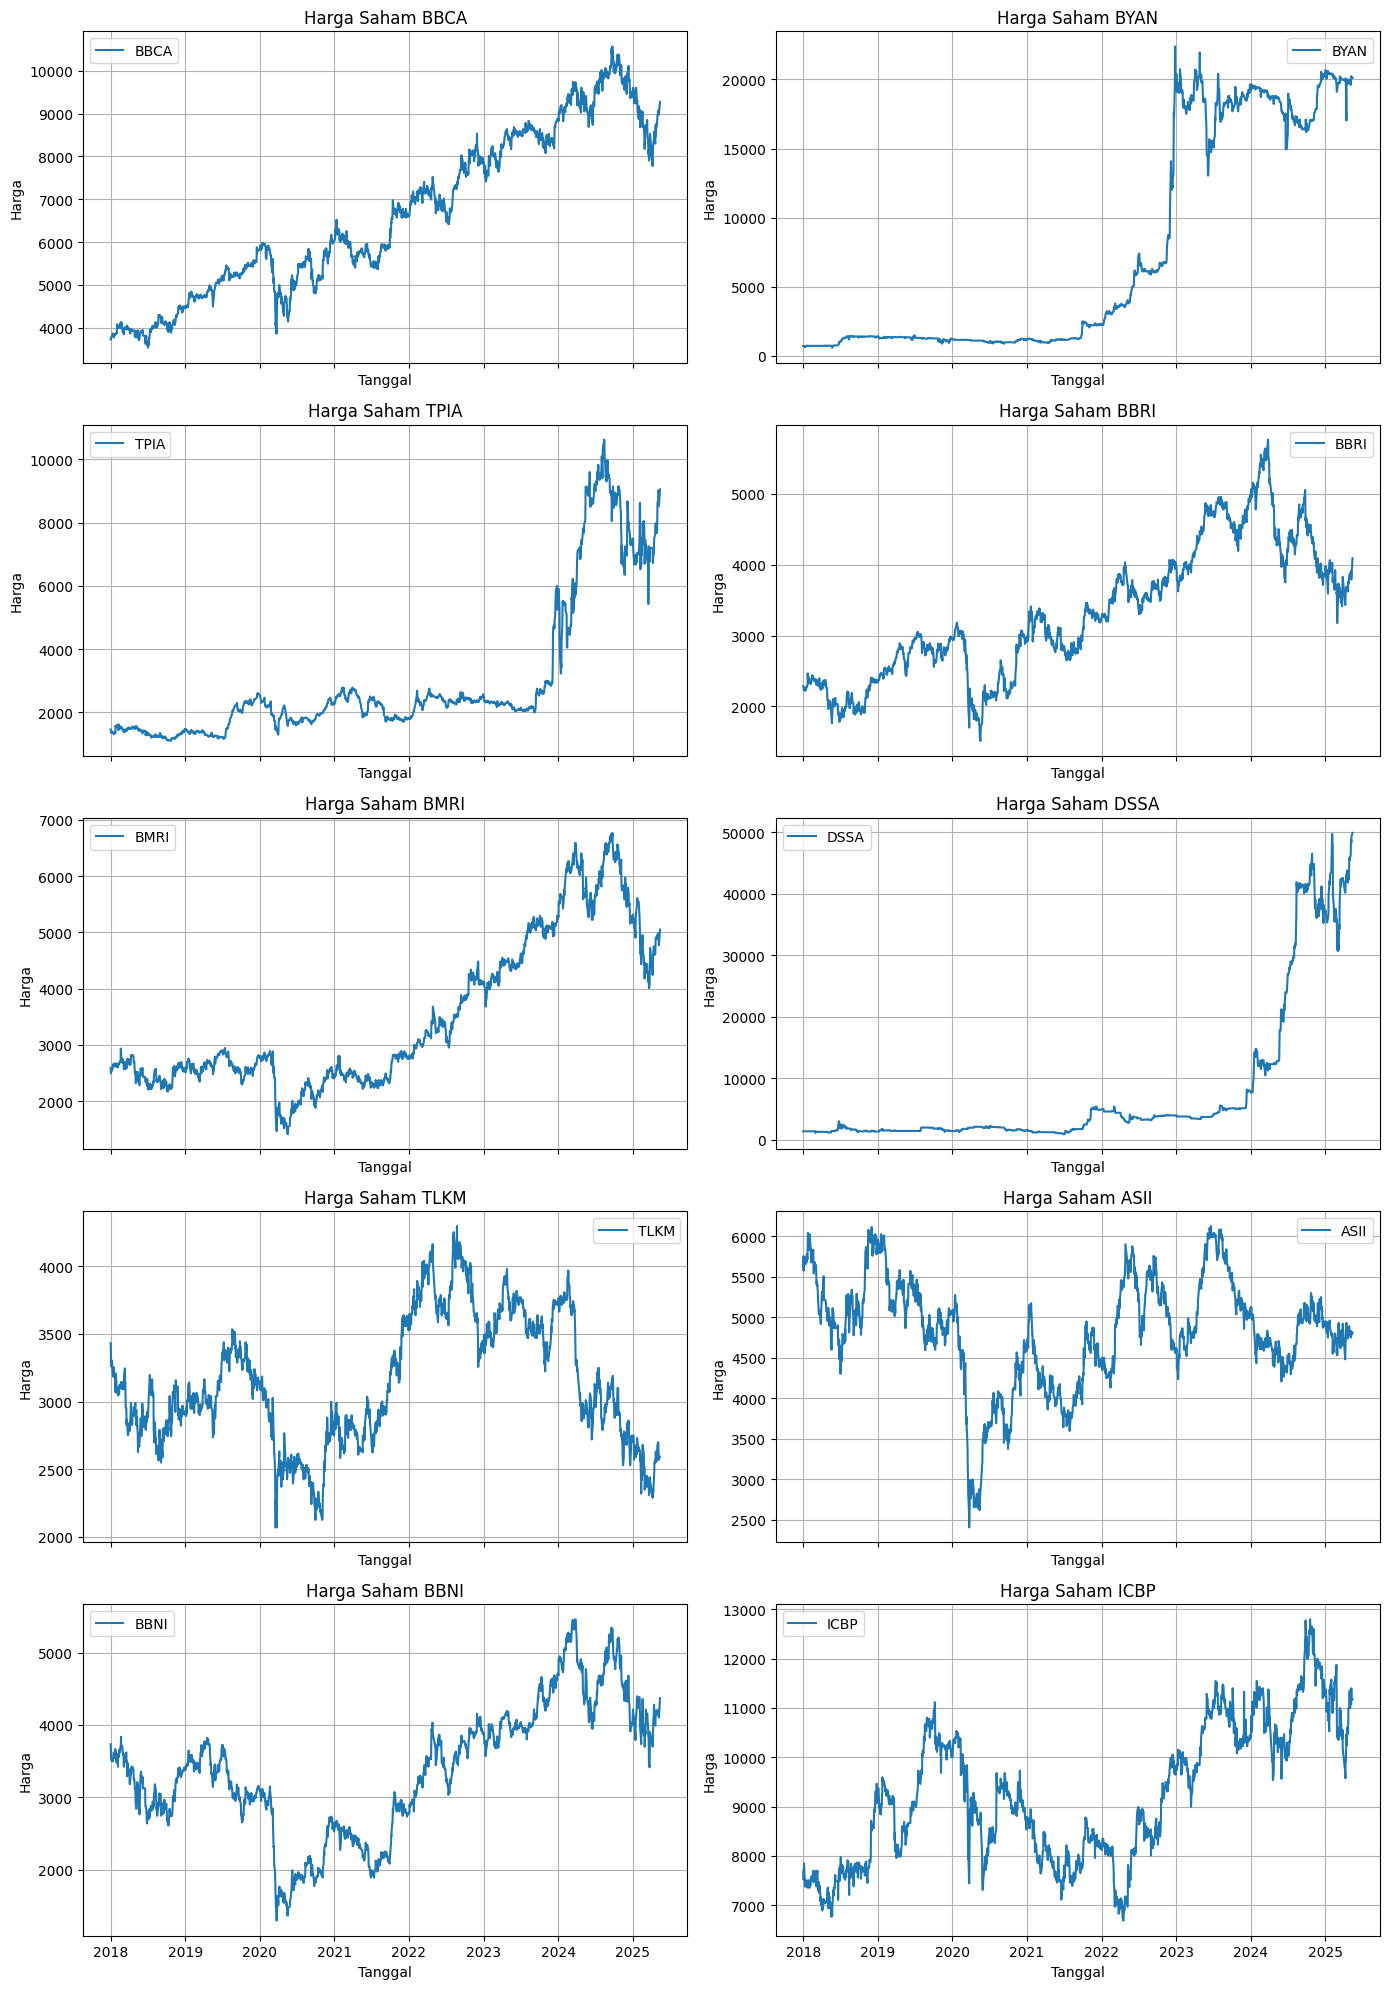

In [42]:
num_stocks = len(stocks.columns)
cols = 2  # jumlah kolom subplot
rows = (num_stocks + cols - 1) // cols  # jumlah baris yang dibutuhkan

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()  # ubah axes jadi array datar agar mudah diakses

for i, stock in enumerate(stocks.columns):
    axes[i].plot(dates, stocks[stock], label=stock)
    axes[i].set_title(f"Harga Saham {stock}")
    axes[i].set_ylabel("Harga")
    axes[i].set_xlabel("Tanggal")
    axes[i].legend()
    axes[i].grid(True)

# Sembunyikan subplot kosong jika jumlah saham ganjil
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Korelasi Antar Saham

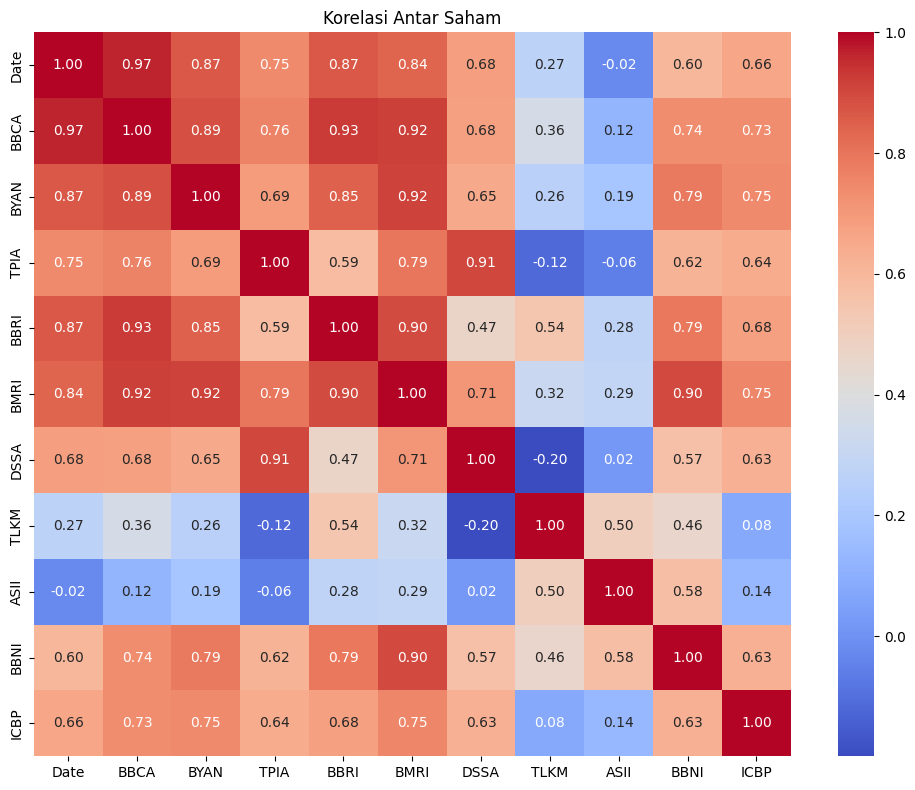

In [18]:
plt.figure(figsize=(10, 8))
correlation_matrix = df_all.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi Antar Saham")
plt.tight_layout()
plt.show()

# Data Preparation

## Simpan Data ke Format CSV

In [43]:
# Saving data to csv
df_all.to_csv("stocks.csv", index=False)

## Normalisasi Data

# Modeling